In [1]:
import time
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from IPython import display
import moviepy.editor as mpy

from dataset import Dataset

Camera position mean & std:
[ -1.9723758  -11.407406     0.36299774] [10.950828   5.4356313 11.073948 ]


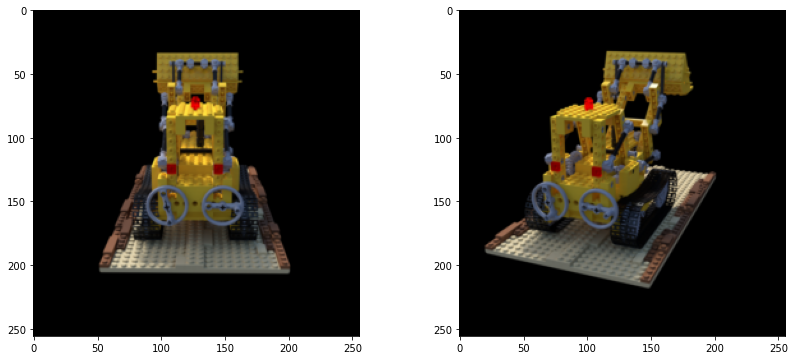

In [2]:
data = Dataset('../public/data/lego', 'blender')
H, W = data.H, data.W

plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.imshow(data.images[0].permute(1,2,0))
plt.subplot(122)
plt.imshow(data.images[1].permute(1,2,0))
plt.show()

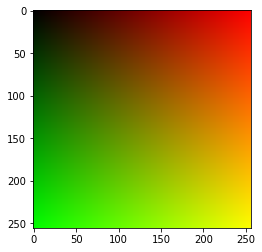

In [3]:
y = data.images[:2].permute(0, 2, 3, 1).reshape(-1, 3).cuda()

i, j = torch.meshgrid(torch.arange(W), torch.arange(H), indexing='xy')
x1 = torch.stack([i / W, j / H, torch.zeros_like(i)], dim=-1)
x2 = x1.clone()
x2[:,:,-1] = 1
x = torch.stack([x1, x2], dim=0).float().cuda()
x_flat = x.reshape(-1, 3)
plt.imshow(x_flat[:H*W].reshape(H, W, 3).cpu())

In [4]:
softplus = nn.Softplus()
omega = 60
n_feats = 128
x_scale = 50

# https://nv-tlabs.github.io/lip-mlp/

class LipLinear(nn.Module):
    def __init__(self, in_features, out_features, c):
        super().__init__()
        self.w = nn.Parameter(torch.randn(
            in_features, out_features, requires_grad=True))
        self.b = nn.Parameter(torch.randn(
            out_features, requires_grad=True))
        self.c = nn.Parameter(torch.tensor(
            [c], dtype=torch.float32, requires_grad=True))
    
    def forward(self, x):
        absrowsum = self.w.abs().sum(dim=1)
        scale = torch.minimum(torch.ones_like(self.c),
                              softplus(self.c) / absrowsum)
        return x @ (self.w * scale[:, None]) + self.b

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        c1 = 1/3/x_scale * n_feats
        c2 = np.sqrt(6/n_feats)/omega * n_feats
        c3 = np.sqrt(6/n_feats)/omega * 3
        layers = [LipLinear(3, n_feats, c1)] \
            + [LipLinear(n_feats, n_feats, c2) for _ in range(3)] \
            + [LipLinear(n_feats, 3, c3)]
        
        with torch.no_grad():
            layers[0].w.uniform_(-1/3/x_scale, 1/3/x_scale)
            for l in layers[1:]:
                l.w.uniform_(-np.sqrt(6/n_feats)/omega,
                             np.sqrt(6/n_feats)/omega)
        
        self.layers = nn.ModuleList(layers)
    
    def forward(self, x):
        h = x.clone()
        h[:, :2] *= x_scale
        for layer in self.layers[:-1]:
            h = layer(h)
            h = torch.sin(omega * h)
        
        h = self.layers[-1](h)
        return h

model = Model().cuda()

mse_fn = nn.MSELoss()
alpha = 1e-4
def loss_fn(output, target):
    mse_loss = mse_fn(output, target)
    C = torch.stack([softplus(l.c) for l in model.layers])
    lip_loss = alpha * C.prod()
    return mse_loss + lip_loss

opt = torch.optim.Adam(model.parameters(), lr=5e-5)
losses = []

3000/3000
1m35s - eta 0s


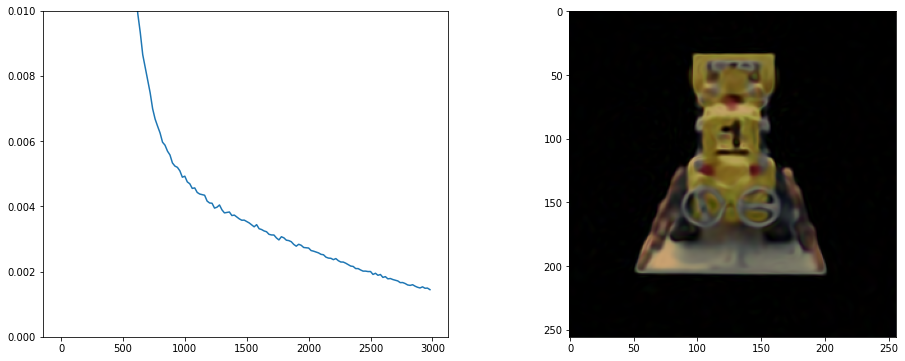

In [5]:
train_st = time.time()
time_to_s = lambda t: (f'{int(t / 60)}m' if t >= 60 else '') + f'{int(t) % 60}s'

n_iter = int(3e3)
batch_size = int(1e5)

for i in range(n_iter):
    sel = np.random.choice(x_flat.shape[0], batch_size)
    pred = model(x_flat[sel])
    loss = loss_fn(pred, y[sel])
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    if (i + 1) % 20 == 0:
        losses.append(loss.item())
    if (i + 1) % 500 == 0:
        display.clear_output(wait=True)
        print(f'{i+1}/{n_iter}')
        time_passed = time.time() - train_st
        eta = time_passed * (n_iter - i) / i
        print(f'{time_to_s(time_passed)} - eta {time_to_s(eta)}')
        plt.figure(figsize=(16, 6))
        plt.subplot(121)
        plt.plot(np.arange(len(losses)) * 20, losses)
        plt.ylim([0, 0.01])
        plt.subplot(122)
        with torch.no_grad():
            pred = model(x_flat[:H*W])
            plt.imshow(pred.clip(0,1).reshape(H, W, 3).cpu())
        plt.show()

In [6]:
saw = lambda x: 1 - abs(x % 2 - 1)
ease_quad = lambda x: 2 * x**2 if x < 0.5 else 1 - (-2 * x + 2)**2 / 2

def make_frame(t):
    t = ease_quad(saw(t))
    bx = (x[0] * (1 - t) + x[1] * t).reshape(-1, 3)
    pred = model(bx)
    img = pred.clip(0, 1).reshape(H, W, 3)
    return img.multiply(255).int().cpu().numpy()

clip = mpy.VideoClip(make_frame, duration=2)
clip.write_videofile('videos/lip.mp4', fps=24)

display.clear_output()
display.display(display.HTML('<video src="videos/lip.mp4" controls=true autoplay=true loop=true />'))